In [32]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt
import time

In [17]:
# set up computational parameters (such as computational region)

# set radius of spatial domain
l = 16

# set number of real space grid points
nx = 1025
# real space spatial grid for the purposes of plotting
xvec = np.linspace(-l, l, nx)

# set number of Fourier basis from n = -nF to n = nF
nF = 256
# matrix for converting Fourier basis coefficients into real space
# wave functions by matrix multiplication
nvec = np.arange(-nF, nF + 1)
Fcnvrmat = np.exp(1j * np.pi * np.outer(nvec, xvec) / l) / np.sqrt(2 * l)

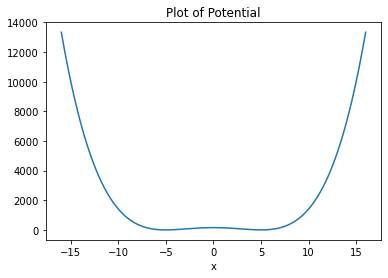

In [18]:
# define potential used to evolve the system

def v(x):
    # dimensionless quantum harmonic oscillator potential
    # return 0.5 * x**2
    # symmetric double well potential
    return 0.25 * (x**2 - 25)**2
    # rescaled symmetric double well potential
    # return 0.0025 * (x**2 - 25)**2
    # scaled asymmetric double well potential
    # return 0.0003*((x-3)**4 + 10*(x-5)**3)
    # soft coulomb potential
    # return -1 / np.sqrt(x**2 + 0.25)

# compute true potential at xvec real space grid points
# vtruvec = v(xvec)

# plot true potential
plt.plot(xvec, v(xvec))
plt.title('Plot of Potential')
plt.xlabel('x')
plt.show()

In [19]:
# transform potential to Fourier basis

# Fres can be adjusted to improve the Fourier basis resolution
# if we set Fres = 1, then Fsample = 2*nfb, which is the
# Nyquist frequency (which is low quality?)
Fres = 100
Fsample = Fres * 2 * nF
# print(Fsample)
Fxvec = np.linspace(-l, l, Fsample + 2, endpoint=False)
# Fvvec = np.fft.rfft(v(Fxvec), norm='forward')[:(2 * nF + 1)]
# this is what Harish uses
Fvvec = (np.fft.rfft(v(Fxvec)) / Fxvec.size)[:(2 * nF + 1)]

# this stores the Fourier series coefficients for n-m=0 to n-m=2*nmax
vrow = Fvvec * (-1)**np.arange(2 * nF + 1)
vmat = sl.toeplitz(r=vrow, c=vrow.conj())

(513,)
(513, 1025)


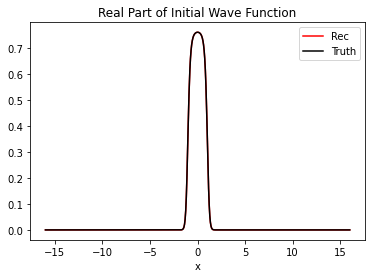

Rel Norm Diff: 4.039895687445461e-09


In [20]:
# define initial state and transform to Fourier basis

# I GET BETTER RESULTS WHEN I USE MY METHOD WHICH NORMALIZES
# THE INITIAL WAVE FUNCTION RATHER THAN USING THE WAVE FUNCTION
# NORMALIZED MANUALLY

def psi0(x):
    # rounded box function
    # return 1.0 + np.tanh((1 - x**2)/0.5)
    # HSB's manually normalized rounded box function
    return (1.0 + np.tanh((1 - x**2)/0.5)) / 2.58046
    # triangular pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])
    # parabolic pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])
    # hyperbolic secant squared
    # return (np.cosh(x))**(-2)
    # Laplace
    # return np.exp(-np.abs(x))

# def mknormpsifn(psifn):
    # compute psi normalization term,
    # this is a constant given some psi
    # psiprobintegrand = lambda x: np.abs(psifn(x))**2
    # normterm = np.sqrt(si.quad(psiprobintegrand, a=-l, b=l)[0])

    # define function for computing normalized psi
    # via scipy.integrate methods
    # def normpsifn(x):
    #     return psifn(x)/normterm

    # return normpsifn

# normpsi0fn = mknormpsifn(psi0)
normpsi0fn = psi0 # when using Harish's psi0
# vector of the normalized psi0 function sampled on the
# real space grid for plotting
normpsi0vec = normpsi0fn(xvec)

# compute the Fourier basis representation of the
# normalized psi0 function using a scipy.integrate method
normpsi0integrand = lambda x: np.exp(-1j * np.pi * nvec * x / l) / np.sqrt(2 * l) * normpsi0fn(x)
normpsi0quadrtn = si.quad_vec(normpsi0integrand, -l, l)[0]
# Fnormpsi0vec = si.quad_vec(normpsi0integrand, -l, l)[0]
print(normpsi0quadrtn.shape)
print(Fcnvrmat.shape)
# Fnormpsi0vecrec2 = normpsi0quadrtn @ Fmat
Fnormpsi0vecrec = normpsi0quadrtn @ Fcnvrmat

# plot the real part of the normalized psi0
plt.plot(xvec, Fnormpsi0vecrec.real, 'r', label="Rec")
plt.plot(xvec, normpsi0vec.real, 'k', label="Truth")
plt.title('Real Part of Initial Wave Function')
plt.xlabel('x')
plt.legend()
plt.show()

print('Rel Norm Diff:', nl.norm(normpsi0vec - Fnormpsi0vecrec) / nl.norm(normpsi0vec))

In [21]:
# construct the kinetic matrix representation of the
# kinetic operator in the Fourier basis
# (this is constant for a given system)
kmat = np.diag(np.arange(-nF, nF + 1)**2 * np.pi**2 / (2 * l**2))

# construct the Hamiltonian matrix representation of the
# Hamiltonian operator in the Fourier basis
hmat = kmat + vmat

# check if the Hamiltonian matrix is Hermitian
print('hmat Hermitian check (should be close to zero):', nl.norm(hmat - hmat.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
spc, stts = nl.eigh(hmat)

# check if the eigendecomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(hmat @ stts - stts @ np.diag(spc)), sep='\n')

# check if the eigenstates are unitary
print('Unitary stts check (should be close to zero):', nl.norm(stts @ stts.conj().T - np.eye(2 * nF + 1)), sep='\n')

hmat Hermitian check (should be close to zero):
0.0
Check if hmat is diagonalized (should be close to zero):
2.2695276922777366e-10
Unitary stts check (should be close to zero):
6.587061893801753e-14


In [22]:
# find indices that sort eigenvalues
ordering = np.argsort(spc)

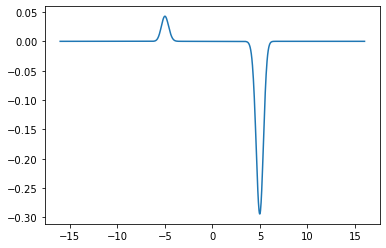

Quick check of Ground state' normalization (should be close to 1):
1.0
Check of Ground state' normalization (should be close to 1):
1.0


In [23]:
# pick out and plot ground state
groundstate = ordering[0]
wavefn = stts[:,groundstate] @ Fcnvrmat
plt.plot(xvec, -np.real(wavefn))
plt.show()

# quick and dirty check if the ground state wave function
# is normalized
print('Quick check of Ground state\' normalization (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Check of Ground state\' normalization (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

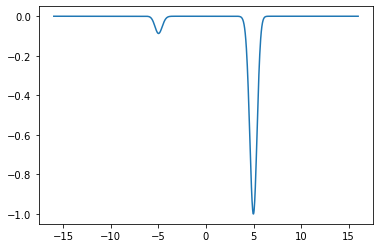

Quick check of Ground state' normalization (should be close to 1):
0.999999999999999
Check of Ground state' normalization (should be close to 1):
0.999999999999999


In [24]:
# pick out and plot the j-th state with j starting at 0
wavefn = stts[:,ordering[1]] @ Fcnvrmat
plt.plot(xvec, np.imag(wavefn))
plt.show()

# quick and dirty check if the ground state wave function
# is normalized
print('Quick check of Ground state\' normalization (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Check of Ground state\' normalization (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

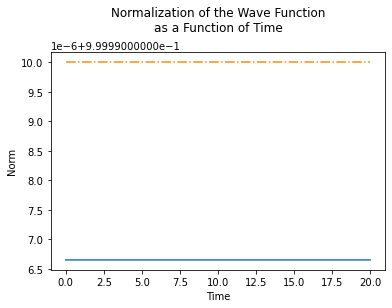

Average Norm of Trajectory (should be close to 1):
0.9999966495232372


In [25]:
# solve the forward problem and generate amat
# set the time step and compute the propagator matrix
# note that we are reusing the spectrum and states from
# the eigendecomposition of Hamiltonian matrix computed above

# set the size of a time step
dt = 0.01

# make the propagator matrix
propamat = stts @ np.diag(np.exp(-1j * spc * dt)) @ stts.conj().T

# set the number of time steps to take starting from
# the initial state (a single trajectory should be
# nts + 1 states, this includes the initial state)
nts = 2000

# propagate the system starting from the initial "a" state
amat = np.zeros((nts + 1, 2 * nF + 1), dtype=np.complex128)
amat[0,:] = normpsi0quadrtn.copy()
for i in range(nts):
    amat[i + 1,:] = propamat @ amat[i,:]

# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
psimatnormvec = si.trapezoid(np.abs(amat @ Fcnvrmat) ** 2, xvec, axis=1)
plt.plot(np.arange(nts + 1) * dt, psimatnormvec)
plt.hlines(1 , 0, nts * dt, linestyles='-.', colors='darkorange')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory (should be close to 1):', psimatnormvec.sum() / (nts + 1), sep='\n')

In [26]:
# we need to make the toeplitz matrix by hand to
# use with JAX grad/jacobian functions, to do this
# we use NumPy/JAX's advance indexing functionality
# it is used in the following way:
# first make a vector which will be used to form the
# toeplitz matrix like:
# toeprepvec = np.concatenate([np.flipud(toeprow.conj()), toeprow[1:]])
# toepmat = toeprepvec[toepindx]
# the output will be the desired toeplitz matrix
ntoep = 2 * nF + 1
toepindx = ((-1) * np.arange(0, ntoep)).reshape(ntoep, 1) + [np.arange(ntoep  -1, 2 * ntoep - 1)]

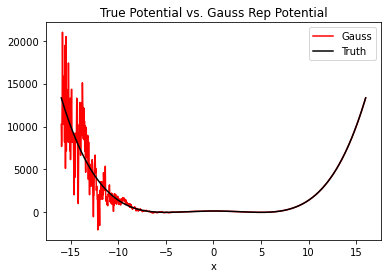

Norm Diff Potentials (should be close to 0):
6768.696411816225
jacGvmat.shape: (2049, 513, 513)


In [61]:
# Gaussian basis model of the potential

# the number of Gaussian basis functions equals 2 * J + 1
J = 1024

# set the width of the Gaussian basis functions
alpha = 4.0

# real space special grid points which determines
# the location of the centers of the Gaussian basis functions
h = l / J
Gxvec = np.arange(-J, J+1) * h

# Gaussian basis matrix used for transforming the Gaussian
# basis coefficients to real space values located at each
# real space grid point
xvecmesh, Gxvecmesh = np.meshgrid(xvec, Gxvec, sparse=True, indexing='ij')
Gmat = np.exp(-alpha * (xvecmesh - Gxvecmesh)**2)

# compute the Gaussian basis coefficients of v(x)
# by solving the equation Gmat @ vcffs = v(Gxvec)
# to compute Gaussian basis coefficients
# Gmat must be a square matrix
Gxvecmesh1, Gxvecmesh2 = np.meshgrid(Gxvec, Gxvec, sparse=True, indexing='ij')
Gmatsqr = np.exp(-alpha * (Gxvecmesh1 - Gxvecmesh2)**2)
# vcffs = sl.solve(Gmatsqr, v(Gxvec), assume_a='sym')
vcffs = jnp.linalg.solve(Gmatsqr, v(Gxvec))

# make real space plot of the potential from the Gaussian
# basis coefficients
plt.plot(xvec, Gmat @ vcffs, 'r', label='Gauss')
plt.plot(xvec, v(xvec), 'k', label='Truth')
plt.title('True Potential vs. Gauss Rep Potential')
plt.xlabel('x')
plt.legend()
plt.show()

print('Norm Diff Potentials (should be close to 0):', jnp.sqrt(si.trapezoid((Gmat @ vcffs - v(xvec))**2, xvec)), sep='\n')

# vector of k-space terms needed to make the potential
# matrix in the Fourier basis representation from Gaussian basis
# coefficients, also for computing the gradient of the
# potential matrix from the Gaussian basis coefficients
Gkvec = np.pi * np.arange(0, 2 * J + 1) / l

# JAX compliant function which generates the toeplitz
# representation of the potential matrix in the Fourier
# basis from a set of Gaussian basis coefficients
# in order to compute the Jacobian of this function
# using JAX the output must be real valued
def mkGvmat(cffs):
    Gkvecmesh, Gxvecmesh = jnp.meshgrid(Gkvec, Gxvec, sparse=True, indexing='ij')
    cnstGFmat = jnp.exp(-1j * Gkvecmesh * Gxvecmesh)
    # print('cnstGFmat.shape:', cnstGFmat.shape)
    cnstexptrm = jnp.exp(-Gkvec ** 2 / (4 * alpha))
    # print('cnstexptrm.shape:', cnstexptrm.shape)
    toeprow = jnp.sqrt(np.pi / alpha) * cnstexptrm / (2 * l) * (cnstGFmat @ cffs)
    flattoep = jnp.concatenate([jnp.flipud(toeprow.conj()), toeprow[1:]])

    # make vmat and return the result
    return flattoep[toepindx]

    # return flattened toeplitz matrix with the real and imaginary parts
    # separated
    # to use jax.jacrev (reverse mode autograd for computing the Jacobian)
    # the output must be real, to do this I spilt the output
    # into real and imaginary parts and concatenate them together
    # return jnp.concatenate([flattoep.real, flattoep.imag])

# gradient of the potential matrix in the Fourier basis
# representation, this is a constant
jacGvmat = np.zeros((2 * J + 1, 2 * nF + 1, 2 * nF + 1), dtype=np.complex128)
for i in range(2 * J + 1):
        thiscffs = np.zeros(2 * J + 1)
        thiscffs[i] = 1

        # this code is for normal operations
        jacGvmat[i] = mkGvmat(thiscffs)

        # this code is used when using jax.jacrev on mkGvmat
        # mkGvmatrtn = mkGvmat(thiscffs)
        # Gvmattoeprep = mkGvmatrtn[:2 * (2 * J + 1) - 1] + 1j * mkGvmatrtn[2 * (2 * J + 1) - 1:]
        # jacGvmat[i] = Gvmattoeprep[toepindx]

print('jacGvmat.shape:', jacGvmat.shape)

# compute Jacobian of mkGvmat using JAX
# jacfnGvtoepvec = jax.jacrev(mkGvmat)
# jacGvtoepvec = jacfnGvtoepvec(vcffs).T
# print('jacGvtoepvec.shape:', jacGvtoepvec.shape)
# jaxjacGvmat = (jacGvtoepvec[:, :2 * (2 * J + 1) - 1] + 1j * jacGvtoepvec[:, 2 * (2 * J + 1) - 1:])[:, toepindx]
# print('jaxjacGvmat.shape:', jaxjacGvmat.shape)

# print('Norm of jacGvmat - jaxjacGvmat (should be close to 0):', nl.norm(jacGvmat - jaxjacGvmat), sep='\n')

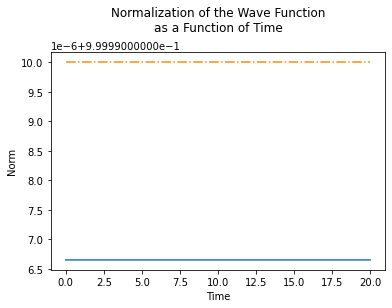

Average Norm of Trajectory (should be close to 1):
0.9999966495218398


In [51]:
# eigendecomposition of Hamiltonian matrix
Gspcvcffs, Gsttsvcffs = jnp.linalg.eigh(kmat + mkGvmat(vcffs))

# propagator matrix
Gpropamatvcffs = Gsttsvcffs @ jnp.diag(np.exp(-1j * Gspcvcffs * dt)) @ Gsttsvcffs.T.conj()

# propagate the "a" vector of Fourier basis coefficients,
# i.e., solve the forward problem
Gamatvcffs = [Fnormpsi0vec]
for i in range(nts):
    Gamatvcffs.append(Gpropamatvcffs @ Gamatvcffs[i])

# make python list of wave Fourier basis wave functions
# a jax object
Gamatvcffs = jnp.stack(Gamatvcffs)

# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
Gpsimatnormvec = si.trapezoid(np.abs(Gamatvcffs @ Fcnvrmat) ** 2, xvec, axis=1)
plt.plot(np.arange(nts + 1) * dt, Gpsimatnormvec)
plt.hlines(1 , 0, nts * dt, linestyles='-.', colors='darkorange')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory (should be close to 1):', Gpsimatnormvec.sum() / (nts + 1), sep='\n')

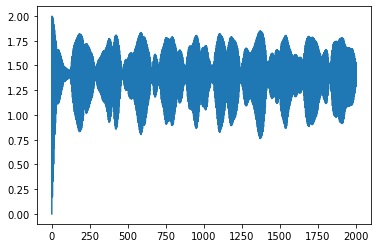

In [54]:
plt.plot(nl.norm(amat - Gamatvcffs, axis=1))
plt.show()

In [28]:
# goal: make a JAX-compliant version

def adjhelper(cffs):
    # construct the Hamiltonian matrix in the Fourier basis
    Ghmat = kmat + mkGvmat(cffs)

    # eigendecomposition of Hamiltonian matrix
    Gspc, Gstts = jnp.linalg.eigh(Ghmat)

    # propagator matrices
    Gpropamat = Gstts @ jnp.diag(np.exp(-1j * Gspc * dt)) @ Gstts.T.conj()
    GpropH = Gstts @ jnp.diag(jnp.exp(1j * Gspc * dt)) @ Gstts.T.conj()

    # propagate the "a" vector of Fourier basis coefficients,
    # i.e., solve the forward problem
    Gamat = [Fnormpsi0vec]
    for i in range(nts):
        Gamat.append(Gpropamat @ Gamat[i])

    # make python list of wave Fourier basis wave functions
    # a jax object
    Gamat = jnp.stack(Gamat)

    # propagate the "lambda" vector of coefficients backward in time,
    # i.e., solve the adjoint problem
    lmat = [Gamat[nts,:] - amat[nts,:]]

    itr = 0 # forward evaluation of lmat
    for i in range(nts - 1, -1, -1):
        lmat.append(Gamat[i,:] - amat[i,:] + GpropH @ lmat[itr] )
        itr += 1

    lmat = jnp.flipud(jnp.stack(lmat))

    offdiagmask = jnp.ones((ntoep, ntoep)) - jnp.eye(ntoep)
    expspec = jnp.exp(-1j * dt * Gspc)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(Gspc, Gspc)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(ntoep)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)
    myeye = jnp.eye(ntoep)
    ws = jnp.hstack([jnp.fliplr(myeye), myeye[:,1:]]).T
    ctrmats = ws[toepindx]
    derivamats = jnp.einsum('ij,jkm,kl->ilm', Gstts.conj().T, ctrmats, Gstts) * jnp.expand_dims(mask, 2)
    alldmatreal = -1j * dt * jnp.einsum('ij,jkm,kl->mil', Gstts, derivamats, Gstts.conj().T)

    ws = 1.0j * jnp.hstack([-jnp.fliplr(myeye), myeye[:, 1:]])
    ws = ws[1:, :]
    ws = ws.T
    ctrmats = ws[toepindx]
    derivamats = jnp.einsum('ij,jkm,kl->ilm', Gstts.conj().T, ctrmats, Gstts) * jnp.expand_dims(mask, 2)
    alldmatimag = -1j*dt*jnp.einsum('ij,jkm,kl->mil', Gstts, derivamats, Gstts.conj().T)

    alldmat = jnp.vstack([alldmatreal, alldmatimag])

    return lmat, alldmat, Gamat

In [29]:
def Gobjfn(cffs):
        # construct the Hamiltonian matrix in the Fourier basis
        Ghmat = kmat + mkGvmat(cffs)

        # eigendecomposition of Hamiltonian matrix
        Gspc, Gstts = jnp.linalg.eigh(Ghmat)

        # propagator matrix
        Gpropamat = Gstts @ jnp.diag(np.exp(-1j * Gspc * dt)) @ Gstts.T.conj()

        # propagate the "a" vector of Fourier basis coefficients,
        # i.e., solve the forward problem
        Gamat = [Fnormpsi0vec]
        for i in range(nts):
            Gamat.append(Gpropamat @ Gamat[i])

        # make python list of wave Fourier basis wave functions
        # a jax object
        Gamat = jnp.stack(Gamat)

        # compute only the objective
        residue = Gamat - amat
        obj = 0.5 * jnp.sum(residue.conj() * residue).real

        return obj

def Ggradfn(cffs):
    lmat, alldmat, Gamat = adjhelper(x)
    # compute all entries of the gradient at once
    gradients = jnp.einsum('ij,ajk,ik->a', jnp.conj(lmat[1:, :]), alldmat, Gamat[:-1, :]).real
    return gradients

In [30]:
Gobjfn(vcffs)

DeviceArray(2000.25307296, dtype=float64)